In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest



import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [3]:
#pzflow_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8' # really smote_suffix 
pzflow_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8' # really smote_suffix 
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

#num=3039 #5000
#n_classes=11 #12
#n_epochs=4000 #500
#pzflow_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
#pzflow_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'
#pzflow_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'


suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{pzflow_suffix}"

#dataset_bank_orig = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_orig_train_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{pzflow_suffix}.csv.gz', compression='gzip', index_col=0)

In [4]:
#train_df_nofakes = dataset_bank_orig[~dataset_bank_orig.index.str.startswith("ZTFabc")]
train_df = dataset_bank_tns_df_resampled_train

test_df = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']

train_df_nofakes.head()

In [5]:
train_df.iloc[:, 0:120].head()

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,5.58494,27.470400,0.085699,0.293200,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,2.17671,4.803750,0.212399,-0.049500,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,6.30388,27.342800,0.059700,0.620701,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,2.79350,6.980380,0.130800,-0.044300,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,6.41716,28.099199,0.218201,0.604300,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821


In [6]:
test_df.iloc[:, 0:120].head()

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,6.25106,21.070999,0.228300,0.401499,0.429100,0.487600,0.394600,0.479000,17.508340,0.363381
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,15.09690,41.370300,0.145802,1.799901,1.987599,2.187201,1.923100,1.677900,127.987642,1.280643
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,5.70474,18.882401,0.207800,0.531799,0.537500,0.461899,0.366699,0.308001,73.202796,0.245163
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,8.80458,35.426399,0.137699,1.232899,1.203501,1.442598,1.337000,1.170200,29.489402,0.282454
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,2.29024,5.506610,0.394201,0.048500,0.024799,-0.047600,0.003399,-0.067900,37.216605,4.749794


In [7]:
Counter(test_df.tns_cls)

Counter({'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

In [8]:
len(test_df.tns_cls)

455

In [9]:
# Test set anomalies (not Ia-normal)
1-(Counter(test_df.tns_cls).get('SN Ia')/len(test_df.tns_cls))

0.29450549450549446

# Not as good results: iso-forest alone (no RFC)

In [10]:
# fit on train_df 
# predict on test_df 
in_out_scores = IsolationForest(n_estimators=500, 
                                random_state=10, 
                                contamination=0.25,
                                max_features=12,
                                n_jobs=-1).fit(train_df.iloc[:, 0:120]).predict(test_df.iloc[:, 0:120])
iso_only_test_df = test_df.copy()
iso_only_test_df['in_out'] = in_out_scores

iso_only_outlier_df = iso_only_test_df[iso_only_test_df['in_out'] == -1]
iso_only_inlier_df = iso_only_test_df[iso_only_test_df['in_out'] == 1]

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [11]:
iso_only_outlier_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group,in_out
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,2.187201,1.923100,1.677900,127.987642,1.280643,Yes_TNS,SN Ic-BL,0.023563,ZTF,-1
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,-0.047600,0.003399,-0.067900,37.216605,4.749794,Yes_TNS,SN Ia,0.070000,ALeRCE,-1
ZTF21aarerya,0.276559,0.853475,0.125000,0.125000,0.308005,0.553118,0.438001,0.143146,4.671850,0.020483,...,-0.098499,-0.087900,-0.230101,7.437063,0.043506,Yes_TNS,SN Ia,0.130000,YSE,-1
ZTF21acivpbd,0.087923,0.346121,0.166667,0.000000,0.405767,0.175846,0.167019,0.087580,-0.294959,0.015438,...,1.995399,2.027600,2.129500,1.261166,1.816040,Yes_TNS,SN II,0.047000,YSE,-1
ZTF21aafjjee,1.241206,0.689426,0.333333,0.000000,0.402912,2.482412,2.225098,1.095818,-0.619467,0.031647,...,1.618999,1.518700,1.122900,142.087370,0.352052,Yes_TNS,SN Ia,0.049180,ALeRCE,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21abfiuqf,0.890352,1.020660,0.260000,0.080000,0.367595,1.590816,0.937048,0.462040,1.521237,0.012031,...,1.221200,1.236300,0.999700,174.629726,1.248133,Yes_TNS,SN II,0.023646,AMPEL,-1
ZTF21aaxwcgj,1.615225,2.271535,0.567568,0.000000,0.444366,3.224883,3.034625,2.295895,-1.594614,0.032740,...,2.015800,1.884899,1.641901,53.950614,0.059645,Yes_TNS,SN Ia,0.032811,ASAS-SN,-1
ZTF21aavqphe,2.030300,0.349804,0.303030,0.000000,0.417832,4.027443,3.627420,1.917728,-0.960976,0.031589,...,1.716900,1.877700,1.878099,67.643434,0.458974,Yes_TNS,SN Ia,0.021000,ALeRCE,-1


In [12]:
Counter(iso_only_test_df.tns_cls)

Counter({'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

In [13]:
Counter(iso_only_outlier_df.tns_cls)

Counter({'SN Ic-BL': 3,
         'SN Ia': 122,
         'SN II': 24,
         'SN IIn': 7,
         'SN Ib': 3,
         'SN Ic': 6,
         'SN Ia-91T-like': 3,
         'SN IIb': 5,
         'SN IIP': 3,
         'TDE': 1})

In [14]:
# contamination of Ia
(Counter(iso_only_outlier_df.tns_cls).get('SN Ia')/len(iso_only_outlier_df.tns_cls))

0.6892655367231638

In [15]:
# outlier_df set anomalies (not Ia-normal)
print("#############")
print(pzflow_suffix)
print("outlier_df set anomalies (not Ia-normal):", round(1-(Counter(iso_only_outlier_df.tns_cls).get('SN Ia')/len(iso_only_outlier_df.tns_cls)), 3))

#############
SMOTE_train_test_70-30_min14_kneighbors8
outlier_df set anomalies (not Ia-normal): 0.311


#############
SMOTE_train_test_80-20_min14_kneighbors8
outlier_df set anomalies (not Ia-normal): 0.294

#############
SMOTE_train_test_70-30_min14_kneighbors8
outlier_df set anomalies (not Ia-normal): 0.311

#############
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
outlier_df set anomalies (not Ia-normal): 0.0
(only 5 anomalies- all Ia)

#############
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
outlier_df set anomalies (not Ia-normal): 0.154

In [16]:
for obj, cls in zip(iso_only_outlier_df.index, iso_only_outlier_df.tns_cls):
    print(f"https://alerce.online/object/{obj}", cls)

https://alerce.online/object/ZTF21acgxypn SN Ic-BL
https://alerce.online/object/ZTF21aaglgcb SN Ia
https://alerce.online/object/ZTF21aarerya SN Ia
https://alerce.online/object/ZTF21acivpbd SN II
https://alerce.online/object/ZTF21aafjjee SN Ia
https://alerce.online/object/ZTF21achfddh SN IIn
https://alerce.online/object/ZTF22aaagrce SN Ib
https://alerce.online/object/ZTF21aamxduf SN Ia
https://alerce.online/object/ZTF22aaagxnb SN Ia
https://alerce.online/object/ZTF20acjsazw SN Ia
https://alerce.online/object/ZTF22aaayewi SN Ia
https://alerce.online/object/ZTF20actlvpy SN Ia
https://alerce.online/object/ZTF21abccaue SN Ib
https://alerce.online/object/ZTF21ackonrq SN Ia
https://alerce.online/object/ZTF21aaahuox SN Ia
https://alerce.online/object/ZTF21acjefpt SN Ia
https://alerce.online/object/ZTF21abbjybk SN Ia
https://alerce.online/object/ZTF18abquxjv SN Ia
https://alerce.online/object/ZTF20adadshh SN Ia
https://alerce.online/object/ZTF21aaygqkb SN Ic
https://alerce.online/object/ZTF21ab

In [17]:
# fit_predict on test_df 
in_out_scores = IsolationForest(n_estimators=500, 
                                random_state=10, 
                                contamination=0.25,
                                max_features=12,
                                n_jobs=-1).fit_predict(test_df.iloc[:, 0:120])
iso_only_test_df = test_df.copy()
iso_only_test_df['in_out'] = in_out_scores

iso_only_outlier_df = iso_only_test_df[iso_only_test_df['in_out'] == -1]
iso_only_inlier_df = iso_only_test_df[iso_only_test_df['in_out'] == 1]

# outlier_df set anomalies (not Ia-normal)
print("#############")
print(pzflow_suffix)
print("outlier_df set anomalies (not Ia-normal):", round(1-(Counter(iso_only_outlier_df.tns_cls).get('SN Ia')/len(iso_only_outlier_df.tns_cls)), 3))

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


#############
SMOTE_train_test_70-30_min14_kneighbors8
outlier_df set anomalies (not Ia-normal): 0.36


#############
SMOTE_train_test_70-30_min14_kneighbors8
outlier_df set anomalies (not Ia-normal): 0.36

#############
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
outlier_df set anomalies (not Ia-normal): 0.36

# BETTER RESULTS: run RFC first, then run IF on RFC prob scores

In [18]:
n_estimators=100 #3500
max_depth=60 #35
random_state=10
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"

In [19]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             random_state=random_state, 
                             max_features=max_features,
                             class_weight=class_weight,
                             verbose=1, 
                             n_jobs=-1)
clf.fit(train_df.iloc[:, 0:120], np.array(train_df['tns_cls']))

pickle.dump(clf, open(f'../pickles/RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}.pkl', 'wb'))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s


CPU times: user 2min 31s, sys: 611 ms, total: 2min 31s
Wall time: 23.1 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished


In [20]:
#with open(f'../pickles/{pzflow_suffix}/PZFLOW_RFC_model_grid_search_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}_class_weight=1-1.pkl', 'rb') as f:
#    clf = pickle.load(f)
    
with open(f'../pickles/RFC_model_n_estimators={n_estimators}_max_depth={max_depth}_random_state={random_state}_max_features={max_features}.pkl', 'rb') as f:
    clf = pickle.load(f)

clf.classes_

array(['None', 'SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [21]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(test_df.iloc[:, 0:120])
predicted_probability

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[16.,  0.,  3., ...,  1.,  0.,  2.],
       [ 7.,  0., 27., ..., 21.,  0.,  0.],
       [26.,  5., 26., ...,  1.,  0., 14.],
       ...,
       [ 2.,  0.,  4., ...,  2.,  0.,  0.],
       [ 5.,  0., 19., ...,  6.,  1.,  0.],
       [15.,  0.,  4., ...,  0.,  2.,  3.]])

In [22]:
Counter(test_df.tns_cls)

Counter({'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

In [23]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(test_df.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
df

,None,SLSN-II,SN II,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,
ZTF21aazebgh,16.0,0.0,3.0,0.0,4.0,1.0,70.0,2.0,1.0,1.0,0.0,2.0,SN Ia
ZTF21acgxypn,7.0,0.0,27.0,6.0,6.0,3.0,13.0,2.0,15.0,21.0,0.0,0.0,SN II
ZTF19aapqqrb,26.0,5.0,26.0,0.0,0.0,2.0,19.0,7.0,0.0,1.0,0.0,14.0,SN II
ZTF21aasbxng,5.0,0.0,27.0,0.0,1.0,5.0,50.0,8.0,0.0,0.0,3.0,1.0,SN Ia
ZTF21aaglgcb,28.0,3.0,11.0,0.0,1.0,1.0,31.0,16.0,3.0,0.0,1.0,5.0,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acdalyp,3.0,0.0,14.0,0.0,7.0,1.0,61.0,8.0,1.0,3.0,0.0,2.0,SN Ia
ZTF21abdcauj,28.0,0.0,1.0,0.0,0.0,2.0,52.0,9.0,0.0,0.0,4.0,4.0,SN Ia
ZTF21aaetnfe,2.0,0.0,4.0,0.0,5.0,2.0,85.0,0.0,0.0,2.0,0.0,0.0,SN Ia


In [24]:
df2 = pd.concat([test_df, df], axis=1)
df2.head()

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIP,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aazebgh,0.401764,0.347613,0.454545,0.000000,0.412583,0.803528,0.769645,0.509926,-1.380175,0.008850,...,0.0,4.0,1.0,70.0,2.0,1.0,1.0,0.0,2.0,SN Ia
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,6.0,6.0,3.0,13.0,2.0,15.0,21.0,0.0,0.0,SN II
ZTF19aapqqrb,0.143625,0.195803,0.428571,0.000000,0.380133,0.287251,0.271332,0.168870,-0.952774,0.003947,...,0.0,0.0,2.0,19.0,7.0,0.0,1.0,0.0,14.0,SN II
ZTF21aasbxng,0.943869,0.500271,0.266667,0.066667,0.355580,1.887737,1.566141,0.461262,0.707341,0.011833,...,0.0,1.0,5.0,50.0,8.0,0.0,0.0,3.0,1.0,SN Ia
ZTF21aaglgcb,0.775517,0.484212,0.363636,0.090909,0.388404,1.551035,1.241484,0.504869,0.962350,-0.014960,...,0.0,1.0,1.0,31.0,16.0,3.0,0.0,1.0,5.0,SN Ia


In [25]:
# df2 set anomalies (not Ia-normal)
1-(Counter(df2.tns_cls).get('SN Ia')/len(df2.tns_cls))

0.29450549450549446

In [26]:
for contamination in np.arange(0.1, 0.55, 0.05):
    contamination=round(contamination, 2)
    in_out_scores = IsolationForest(n_estimators=500, 
                                    random_state=10, 
                                    contamination=contamination,
                                    max_features=12,
                                    n_jobs=-1).fit_predict(predicted_probability)
    df2['in_out'] = in_out_scores

    outlier_df = df2[df2['in_out'] == -1]
    inlier_df = df2[df2['in_out'] == 1]

    print("#####################")
    print(pzflow_suffix)
    print(f"Contamination={contamination} | {len(outlier_df)} Objects | {round(len(outlier_df[outlier_df.tns_cls == 'SN Ia'])/len(outlier_df), 2)} SN Ia contam.")
    for cls in np.unique(test_df.tns_cls):
        print(f"{cls}: {len(outlier_df[outlier_df.tns_cls == cls])}/{len(test_df[test_df.tns_cls == cls])}={round(len(outlier_df[outlier_df.tns_cls == cls])/len(test_df[test_df.tns_cls == cls]), 3)} \n")
        # df2 set anomalies (not Ia-normal)
    print("outlier_df (RFC->IF) anomalies (not Ia-normal):", 1-(Counter(outlier_df.tns_cls).get('SN Ia')/len(outlier_df.tns_cls)))

#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.1 | 46 Objects | 0.26 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 15/68=0.221 

SN IIP: 0/5=0.0 

SN IIb: 1/6=0.167 

SN IIn: 7/15=0.467 

SN Ia: 12/321=0.037 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 2/9=0.222 

SN Ic-BL: 2/5=0.4 

TDE: 4/8=0.5 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7391304347826086
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.15 | 69 Objects | 0.29 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 23/68=0.338 

SN IIP: 1/5=0.2 

SN IIb: 2/6=0.333 

SN IIn: 9/15=0.6 

SN Ia: 20/321=0.062 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 3/6=0.5 

SN Ic: 3/9=0.333 

SN Ic-BL: 2/5=0.4 

TDE: 5/8=0.625 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7101449275362319
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.2 | 91 Objects | 0.3 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 29/68=0.426 

SN IIP: 3/5=0.6 

SN IIb: 2/6=0.333 


# BEST is SMOTE fakes at 70/30. Better than PZFLOW at 70/30 for same dataset.
# SMOTE at 80/20 is similar to PZFLOW at 80/20...

#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.2 | 91 Objects | 0.3 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 29/68=0.426 

SN IIP: 3/5=0.6 

SN IIb: 2/6=0.333 

SN IIn: 12/15=0.8 

SN Ia: 27/321=0.084 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 3/6=0.5 

SN Ic: 4/9=0.444 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7032967032967032

#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.25 | 114 Objects | 0.32 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 38/68=0.559 

SN IIP: 3/5=0.6 

SN IIb: 2/6=0.333 

SN IIn: 12/15=0.8 

SN Ia: 37/321=0.115 

SN Ia-91T-like: 2/9=0.222 

SN Ib: 5/6=0.833 

SN Ic: 4/9=0.444 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6754385964912281

## STORE ALL RESULTS

#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.1 | 46 Objects | 0.26 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 18/68=0.265 

SN IIP: 2/5=0.4 

SN IIb: 3/6=0.5 

SN IIn: 1/15=0.067 

SN Ia: 12/321=0.037 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 5/9=0.556 

SN Ic-BL: 2/5=0.4 

TDE: 0/8=0.0 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7391304347826086
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.15 | 69 Objects | 0.35 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 25/68=0.368 

SN IIP: 2/5=0.4 

SN IIb: 3/6=0.5 

SN IIn: 3/15=0.2 

SN Ia: 24/321=0.075 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 6/9=0.667 

SN Ic-BL: 2/5=0.4 

TDE: 1/8=0.125 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6521739130434783
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.2 | 91 Objects | 0.38 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 35/68=0.515 

SN IIP: 2/5=0.4 

SN IIb: 3/6=0.5 

SN IIn: 4/15=0.267 

SN Ia: 35/321=0.109 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 6/9=0.667 

SN Ic-BL: 2/5=0.4 

TDE: 1/8=0.125 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6153846153846154
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.25 | 114 Objects | 0.43 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 39/68=0.574 

SN IIP: 2/5=0.4 

SN IIb: 3/6=0.5 

SN IIn: 5/15=0.333 

SN Ia: 49/321=0.153 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 7/9=0.778 

SN Ic-BL: 2/5=0.4 

TDE: 3/8=0.375 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5701754385964912
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.3 | 137 Objects | 0.47 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 44/68=0.647 

SN IIP: 3/5=0.6 

SN IIb: 3/6=0.5 

SN IIn: 7/15=0.467 

SN Ia: 64/321=0.199 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 7/9=0.778 

SN Ic-BL: 2/5=0.4 

TDE: 3/8=0.375 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5328467153284672
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.35 | 159 Objects | 0.49 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 48/68=0.706 

SN IIP: 3/5=0.6 

SN IIb: 3/6=0.5 

SN IIn: 9/15=0.6 

SN Ia: 78/321=0.243 

SN Ia-91T-like: 1/9=0.111 

SN Ib: 2/6=0.333 

SN Ic: 7/9=0.778 

SN Ic-BL: 2/5=0.4 

TDE: 4/8=0.5 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5094339622641509
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.4 | 182 Objects | 0.53 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 49/68=0.721 

SN IIP: 3/5=0.6 

SN IIb: 3/6=0.5 

SN IIn: 10/15=0.667 

SN Ia: 97/321=0.302 

SN Ia-91T-like: 1/9=0.111 

SN Ib: 2/6=0.333 

SN Ic: 7/9=0.778 

SN Ic-BL: 2/5=0.4 

TDE: 6/8=0.75 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.46703296703296704
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.45 | 205 Objects | 0.54 SN Ia contam.
SLSN-II: 3/3=1.0 

SN II: 52/68=0.765 

SN IIP: 4/5=0.8 

SN IIb: 3/6=0.5 

SN IIn: 12/15=0.8 

SN Ia: 110/321=0.343 

SN Ia-91T-like: 3/9=0.333 

SN Ib: 2/6=0.333 

SN Ic: 7/9=0.778 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.46341463414634143
#####################
PZFLOW_train_test_70-30_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.5 | 227 Objects | 0.55 SN Ia contam.
SLSN-II: 3/3=1.0 

SN II: 55/68=0.809 

SN IIP: 4/5=0.8 

SN IIb: 3/6=0.5 

SN IIn: 13/15=0.867 

SN Ia: 124/321=0.386 

SN Ia-91T-like: 5/9=0.556 

SN Ib: 3/6=0.5 

SN Ic: 8/9=0.889 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.45374449339207046
​


#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.1 | 30 Objects | 0.27 SN Ia contam.
SN II: 10/43=0.233 

SN IIP: 2/3=0.667 

SN IIb: 1/4=0.25 

SN IIn: 3/9=0.333 

SN Ia: 8/216=0.037 

SN Ia-91T-like: 0/6=0.0 

SN Ib: 0/5=0.0 

SN Ic: 1/5=0.2 

SN Ic-BL: 2/2=1.0 

TDE: 3/7=0.429 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7333333333333334
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.15 | 45 Objects | 0.31 SN Ia contam.
SN II: 15/43=0.349 

SN IIP: 2/3=0.667 

SN IIb: 1/4=0.25 

SN IIn: 6/9=0.667 

SN Ia: 14/216=0.065 

SN Ia-91T-like: 0/6=0.0 

SN Ib: 1/5=0.2 

SN Ic: 1/5=0.2 

SN Ic-BL: 2/2=1.0 

TDE: 3/7=0.429 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6888888888888889
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.2 | 60 Objects | 0.37 SN Ia contam.
SN II: 19/43=0.442 

SN IIP: 2/3=0.667 

SN IIb: 1/4=0.25 

SN IIn: 6/9=0.667 

SN Ia: 22/216=0.102 

SN Ia-91T-like: 0/6=0.0 

SN Ib: 2/5=0.4 

SN Ic: 1/5=0.2 

SN Ic-BL: 2/2=1.0 

TDE: 5/7=0.714 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6333333333333333
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.25 | 75 Objects | 0.41 SN Ia contam.
SN II: 22/43=0.512 

SN IIP: 2/3=0.667 

SN IIb: 1/4=0.25 

SN IIn: 6/9=0.667 

SN Ia: 31/216=0.144 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 3/5=0.6 

SN Ic: 2/5=0.4 

SN Ic-BL: 2/2=1.0 

TDE: 5/7=0.714 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5866666666666667
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.3 | 90 Objects | 0.43 SN Ia contam.
SN II: 25/43=0.581 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 6/9=0.667 

SN Ia: 39/216=0.181 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 5/5=1.0 

SN Ic: 2/5=0.4 

SN Ic-BL: 2/2=1.0 

TDE: 5/7=0.714 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5666666666666667
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.35 | 105 Objects | 0.49 SN Ia contam.
SN II: 28/43=0.651 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 6/9=0.667 

SN Ia: 51/216=0.236 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 5/5=1.0 

SN Ic: 2/5=0.4 

SN Ic-BL: 2/2=1.0 

TDE: 5/7=0.714 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5142857142857142
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.4 | 120 Objects | 0.51 SN Ia contam.
SN II: 32/43=0.744 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 6/9=0.667 

SN Ia: 61/216=0.282 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 5/5=1.0 

SN Ic: 2/5=0.4 

SN Ic-BL: 2/2=1.0 

TDE: 6/7=0.857 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.4916666666666667
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.45 | 135 Objects | 0.52 SN Ia contam.
SN II: 36/43=0.837 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 6/9=0.667 

SN Ia: 70/216=0.324 

SN Ia-91T-like: 2/6=0.333 

SN Ib: 5/5=1.0 

SN Ic: 3/5=0.6 

SN Ic-BL: 2/2=1.0 

TDE: 6/7=0.857 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.4814814814814815
#####################
SMOTE_train_test_80-20_min14_kneighbors8
Contamination=0.5 | 150 Objects | 0.55 SN Ia contam.
SN II: 38/43=0.884 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 7/9=0.778 

SN Ia: 82/216=0.38 

SN Ia-91T-like: 2/6=0.333 

SN Ib: 5/5=1.0 

SN Ic: 3/5=0.6 

SN Ic-BL: 2/2=1.0 

TDE: 6/7=0.857 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.45333333333333337

#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.1 | 46 Objects | 0.26 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 15/68=0.221 

SN IIP: 0/5=0.0 

SN IIb: 1/6=0.167 

SN IIn: 7/15=0.467 

SN Ia: 12/321=0.037 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 2/6=0.333 

SN Ic: 2/9=0.222 

SN Ic-BL: 2/5=0.4 

TDE: 4/8=0.5 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7391304347826086
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.15 | 69 Objects | 0.29 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 23/68=0.338 

SN IIP: 1/5=0.2 

SN IIb: 2/6=0.333 

SN IIn: 9/15=0.6 

SN Ia: 20/321=0.062 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 3/6=0.5 

SN Ic: 3/9=0.333 

SN Ic-BL: 2/5=0.4 

TDE: 5/8=0.625 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7101449275362319
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.2 | 91 Objects | 0.3 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 29/68=0.426 

SN IIP: 3/5=0.6 

SN IIb: 2/6=0.333 

SN IIn: 12/15=0.8 

SN Ia: 27/321=0.084 

SN Ia-91T-like: 0/9=0.0 

SN Ib: 3/6=0.5 

SN Ic: 4/9=0.444 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7032967032967032
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.25 | 114 Objects | 0.32 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 38/68=0.559 

SN IIP: 3/5=0.6 

SN IIb: 2/6=0.333 

SN IIn: 12/15=0.8 

SN Ia: 37/321=0.115 

SN Ia-91T-like: 2/9=0.222 

SN Ib: 5/6=0.833 

SN Ic: 4/9=0.444 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6754385964912281
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.3 | 137 Objects | 0.36 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 44/68=0.647 

SN IIP: 4/5=0.8 

SN IIb: 2/6=0.333 

SN IIn: 13/15=0.867 

SN Ia: 49/321=0.153 

SN Ia-91T-like: 3/9=0.333 

SN Ib: 5/6=0.833 

SN Ic: 5/9=0.556 

SN Ic-BL: 3/5=0.6 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6423357664233577
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.35 | 159 Objects | 0.4 SN Ia contam.
SLSN-II: 3/3=1.0 

SN II: 49/68=0.721 

SN IIP: 4/5=0.8 

SN IIb: 2/6=0.333 

SN IIn: 14/15=0.933 

SN Ia: 63/321=0.196 

SN Ia-91T-like: 3/9=0.333 

SN Ib: 5/6=0.833 

SN Ic: 5/9=0.556 

SN Ic-BL: 3/5=0.6 

TDE: 8/8=1.0 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6037735849056604
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.4 | 182 Objects | 0.44 SN Ia contam.
SLSN-II: 3/3=1.0 

SN II: 52/68=0.765 

SN IIP: 5/5=1.0 

SN IIb: 3/6=0.5 

SN IIn: 15/15=1.0 

SN Ia: 80/321=0.249 

SN Ia-91T-like: 3/9=0.333 

SN Ib: 5/6=0.833 

SN Ic: 5/9=0.556 

SN Ic-BL: 3/5=0.6 

TDE: 8/8=1.0 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5604395604395604
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.45 | 205 Objects | 0.46 SN Ia contam.
SLSN-II: 3/3=1.0 

SN II: 56/68=0.824 

SN IIP: 5/5=1.0 

SN IIb: 4/6=0.667 

SN IIn: 15/15=1.0 

SN Ia: 95/321=0.296 

SN Ia-91T-like: 5/9=0.556 

SN Ib: 5/6=0.833 

SN Ic: 6/9=0.667 

SN Ic-BL: 3/5=0.6 

TDE: 8/8=1.0 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5365853658536586
#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.5 | 227 Objects | 0.5 SN Ia contam.
SLSN-II: 3/3=1.0 

SN II: 59/68=0.868 

SN IIP: 5/5=1.0 

SN IIb: 4/6=0.667 

SN IIn: 15/15=1.0 

SN Ia: 114/321=0.355 

SN Ia-91T-like: 5/9=0.556 

SN Ib: 5/6=0.833 

SN Ic: 6/9=0.667 

SN Ic-BL: 3/5=0.6 

TDE: 8/8=1.0 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.4977973568281938

#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.1 | 30 Objects | 0.23 SN Ia contam.
SN II: 12/43=0.279 

SN IIP: 1/3=0.333 

SN IIb: 2/4=0.5 

SN IIn: 1/9=0.111 

SN Ia: 7/216=0.032 

SN Ia-91T-like: 0/6=0.0 

SN Ib: 1/5=0.2 

SN Ic: 3/5=0.6 

SN Ic-BL: 2/2=1.0 

TDE: 1/7=0.143 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7666666666666666
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.15 | 45 Objects | 0.29 SN Ia contam.
SN II: 19/43=0.442 

SN IIP: 1/3=0.333 

SN IIb: 2/4=0.5 

SN IIn: 2/9=0.222 

SN Ia: 13/216=0.06 

SN Ia-91T-like: 0/6=0.0 

SN Ib: 1/5=0.2 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 1/7=0.143 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.7111111111111111
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.2 | 60 Objects | 0.37 SN Ia contam.
SN II: 22/43=0.512 

SN IIP: 2/3=0.667 

SN IIb: 2/4=0.5 

SN IIn: 2/9=0.222 

SN Ia: 22/216=0.102 

SN Ia-91T-like: 0/6=0.0 

SN Ib: 1/5=0.2 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 3/7=0.429 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6333333333333333
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.25 | 75 Objects | 0.43 SN Ia contam.
SN II: 24/43=0.558 

SN IIP: 2/3=0.667 

SN IIb: 2/4=0.5 

SN IIn: 2/9=0.222 

SN Ia: 32/216=0.148 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 2/5=0.4 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 4/7=0.571 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5733333333333333
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.3 | 90 Objects | 0.49 SN Ia contam.
SN II: 26/43=0.605 

SN IIP: 2/3=0.667 

SN IIb: 2/4=0.5 

SN IIn: 3/9=0.333 

SN Ia: 44/216=0.204 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 2/5=0.4 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 4/7=0.571 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.5111111111111111
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.35 | 105 Objects | 0.51 SN Ia contam.
SN II: 27/43=0.628 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 6/9=0.667 

SN Ia: 54/216=0.25 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 2/5=0.4 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 4/7=0.571 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.48571428571428577
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.4 | 120 Objects | 0.56 SN Ia contam.
SN II: 28/43=0.651 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 7/9=0.778 

SN Ia: 67/216=0.31 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 2/5=0.4 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 4/7=0.571 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.44166666666666665
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.45 | 135 Objects | 0.59 SN Ia contam.
SN II: 30/43=0.698 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 8/9=0.889 

SN Ia: 79/216=0.366 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 2/5=0.4 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 4/7=0.571 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.41481481481481486
#####################
PZFLOW_train_test_80-20_min14_classes11_epochs4000_n3039_RollingSplineCoupling_B=5_chunks20
Contamination=0.5 | 150 Objects | 0.59 SN Ia contam.
SN II: 33/43=0.767 

SN IIP: 3/3=1.0 

SN IIb: 2/4=0.5 

SN IIn: 8/9=0.889 

SN Ia: 89/216=0.412 

SN Ia-91T-like: 1/6=0.167 

SN Ib: 2/5=0.4 

SN Ic: 4/5=0.8 

SN Ic-BL: 2/2=1.0 

TDE: 6/7=0.857 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.4066666666666666

# OneClassSVM (Not as good as RFC --> IF)

In [27]:
from sklearn.svm import OneClassSVM

in_out_scores = OneClassSVM(kernel='linear', 
                            gamma='auto', 
                           ).fit_predict(predicted_probability)

df3 = df2.copy()
df3['in_out'] = in_out_scores
outlier_df3 = df3[df3['in_out'] < 0]
inlier_df3 = df3[df3['in_out'] >= 0]

print("#####################")
print(pzflow_suffix)
print(f"OneClassSVM | {len(outlier_df3)} Objects | {round(len(outlier_df3[outlier_df3.tns_cls == 'SN Ia'])/len(outlier_df3), 2)} SN Ia contam.")
for cls in np.unique(test_df.tns_cls):
    print(f"{cls}: {len(outlier_df3[outlier_df3.tns_cls == cls])}/{len(test_df[test_df.tns_cls == cls])}={round(len(outlier_df3[outlier_df3.tns_cls == cls])/len(test_df[test_df.tns_cls == cls]), 3)} \n")
    # df2 set anomalies (not Ia-normal)
print("outlier_df (RFC->IF) anomalies (not Ia-normal):", 1-(Counter(outlier_df3.tns_cls).get('SN Ia')/len(outlier_df3.tns_cls)))

#####################
SMOTE_train_test_70-30_min14_kneighbors8
OneClassSVM | 228 Objects | 0.56 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 49/68=0.721 

SN IIP: 4/5=0.8 

SN IIb: 5/6=0.833 

SN IIn: 14/15=0.933 

SN Ia: 128/321=0.399 

SN Ia-91T-like: 4/9=0.444 

SN Ib: 5/6=0.833 

SN Ic: 5/9=0.556 

SN Ic-BL: 4/5=0.8 

TDE: 8/8=1.0 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.4385964912280702


# LocalOutlierFactor (Not as good as RFC --> IF)

In [28]:
from sklearn.neighbors import LocalOutlierFactor

for nn in range(1, 50, 5):
    in_out_scores = LocalOutlierFactor(n_neighbors=nn, 
                                       algorithm='auto',
                                       metric='manhattan',
                                       contamination=0.25,
                                       n_jobs=-1).fit_predict(predicted_probability)

    df4 = df2.copy()
    df4['in_out'] = in_out_scores
    outlier_df4 = df4[df4['in_out'] < 0]
    inlier_df4 = df4[df4['in_out'] >= 0]

    print(f"##################### n ={nn}")
    print(pzflow_suffix)
    print(f"LocalOutlierFactor | {len(outlier_df4)} Objects | {round(len(outlier_df4[outlier_df4.tns_cls == 'SN Ia'])/len(outlier_df4), 2)} SN Ia contam.")
    for cls in np.unique(test_df.tns_cls):
        print(f"{cls}: {len(outlier_df4[outlier_df4.tns_cls == cls])}/{len(test_df[test_df.tns_cls == cls])}={round(len(outlier_df4[outlier_df4.tns_cls == cls])/len(test_df[test_df.tns_cls == cls]), 3)} \n")
        # df2 set anomalies (not Ia-normal)
    print("outlier_df (RFC->IF) anomalies (not Ia-normal):", 1-(Counter(outlier_df4.tns_cls).get('SN Ia')/len(outlier_df4.tns_cls)))

##################### n =1
SMOTE_train_test_70-30_min14_kneighbors8
LocalOutlierFactor | 114 Objects | 0.69 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 18/68=0.265 

SN IIP: 0/5=0.0 

SN IIb: 1/6=0.167 

SN IIn: 4/15=0.267 

SN Ia: 79/321=0.246 

SN Ia-91T-like: 2/9=0.222 

SN Ib: 1/6=0.167 

SN Ic: 2/9=0.222 

SN Ic-BL: 3/5=0.6 

TDE: 3/8=0.375 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.3070175438596491
##################### n =6
SMOTE_train_test_70-30_min14_kneighbors8
LocalOutlierFactor | 114 Objects | 0.66 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 12/68=0.176 

SN IIP: 1/5=0.2 

SN IIb: 1/6=0.167 

SN IIn: 8/15=0.533 

SN Ia: 75/321=0.234 

SN Ia-91T-like: 1/9=0.111 

SN Ib: 2/6=0.333 

SN Ic: 3/9=0.333 

SN Ic-BL: 3/5=0.6 

TDE: 6/8=0.75 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.3421052631578947
##################### n =11
SMOTE_train_test_70-30_min14_kneighbors8
LocalOutlierFactor | 114 Objects | 0.61 SN Ia contam.
SLSN-II: 1/3=0.333 

SN II: 17/68=0.25 

SN IIP:

# EXPLORE BEST RESULTS (SMOTE)
# RFC -> IF

In [29]:
contamination=0.25
in_out_scores = IsolationForest(n_estimators=500, 
                                random_state=10, 
                                contamination=contamination,
                                max_features=12,
                                n_jobs=-1).fit_predict(predicted_probability)
df2['in_out'] = in_out_scores

outlier_df = df2[df2['in_out'] == -1]
inlier_df = df2[df2['in_out'] == 1]

print("#####################")
print(pzflow_suffix)
print(f"Contamination={contamination} | {len(outlier_df)} Objects | {round(len(outlier_df[outlier_df.tns_cls == 'SN Ia'])/len(outlier_df), 2)} SN Ia contam.")
for cls in np.unique(test_df.tns_cls):
    print(f"{cls}: {len(outlier_df[outlier_df.tns_cls == cls])}/{len(test_df[test_df.tns_cls == cls])}={round(len(outlier_df[outlier_df.tns_cls == cls])/len(test_df[test_df.tns_cls == cls]), 3)} \n")
print("outlier_df (RFC->IF) anomalies (not Ia-normal):", 1-(Counter(outlier_df.tns_cls).get('SN Ia')/len(outlier_df.tns_cls)))

#####################
SMOTE_train_test_70-30_min14_kneighbors8
Contamination=0.25 | 114 Objects | 0.32 SN Ia contam.
SLSN-II: 2/3=0.667 

SN II: 38/68=0.559 

SN IIP: 3/5=0.6 

SN IIb: 2/6=0.333 

SN IIn: 12/15=0.8 

SN Ia: 37/321=0.115 

SN Ia-91T-like: 2/9=0.222 

SN Ib: 5/6=0.833 

SN Ic: 4/9=0.444 

SN Ic-BL: 2/5=0.4 

TDE: 7/8=0.875 

outlier_df (RFC->IF) anomalies (not Ia-normal): 0.6754385964912281


In [30]:
# all "anomalies"
for obj, cls, z, rfc_cls in zip(outlier_df.index, outlier_df.tns_cls, outlier_df.spec_z, outlier_df.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, round(z, 3), rfc_cls)

https://alerce.online/object/ZTF21acgxypn SN Ic-BL 0.024 SN II
https://alerce.online/object/ZTF19aapqqrb SN Ia 0.048 SN II
https://alerce.online/object/ZTF21abgkfzh SN IIn 0.086 SN IIn
https://alerce.online/object/ZTF21acivpbd SN II 0.047 SN II
https://alerce.online/object/ZTF21achfddh SN IIn 0.07 SN II
https://alerce.online/object/ZTF22aaagrce SN Ib 0.035 SN Ia
https://alerce.online/object/ZTF21abplgag SN Ia 0.075 SN Ia
https://alerce.online/object/ZTF21abccaue SN Ib 0.04 SN II
https://alerce.online/object/ZTF21aaahuox SN Ia 0.074 SN Ia
https://alerce.online/object/ZTF20achmmex SN II 0.032 SN II
https://alerce.online/object/ZTF21abtephz SN II 0.023 SN Ia
https://alerce.online/object/ZTF20acngnrs SN IIP 0.069 SN II
https://alerce.online/object/ZTF21aaygqkb SN Ic 0.023 SN II
https://alerce.online/object/ZTF21acqyqwu SN Ib 0.042 SN II
https://alerce.online/object/ZTF20acvdqtg SN Ia 0.077 SN Ia
https://alerce.online/object/ZTF20abarsvz SN Ia 0.039 SN Ia
https://alerce.online/object/ZTF20a

https://alerce.online/object/ZTF21acgxypn SN Ic-BL 0.024 SN II - rare
https://alerce.online/object/ZTF19aapqqrb SN Ia 0.048 SN II - NOT rare (but no fall in lc), elliptical
https://alerce.online/object/ZTF21abgkfzh SN IIn 0.086 SN IIn - rare
https://alerce.online/object/ZTF21acivpbd SN II 0.047 SN II - rare
https://alerce.online/object/ZTF21achfddh SN IIn 0.07 SN II - rare
https://alerce.online/object/ZTF22aaagrce SN Ib 0.035 SN Ia - rare
https://alerce.online/object/ZTF21abplgag SN Ia 0.075 SN Ia - NOT rare (normal looking Ia, not much rise), elliptical
https://alerce.online/object/ZTF21abccaue SN Ib 0.04 SN II - rare
https://alerce.online/object/ZTF21aaahuox SN Ia 0.074 SN Ia - NOT rare (normal looking Ia, not much rise, gappy), hostless or elliptical (offset). Looks really similar to ZTF21abplgag
https://alerce.online/object/ZTF20achmmex SN II 0.032 SN II - rare
https://alerce.online/object/ZTF21abtephz SN II 0.023 SN Ia - rare
https://alerce.online/object/ZTF20acngnrs SN IIP 0.069 SN II - rare
https://alerce.online/object/ZTF21aaygqkb SN Ic 0.023 SN II - rare
https://alerce.online/object/ZTF21acqyqwu SN Ib 0.042 SN II - rare
https://alerce.online/object/ZTF20acvdqtg SN Ia 0.077 SN Ia - NOT rare (normal looking Ia, not much rise), elliptical. Looks really similar to ZTF21abplgag and ZTF21aaahuox...(why? all z~0.07 too...)
https://alerce.online/object/ZTF20abarsvz SN Ia 0.039 SN Ia - NOT rare but Understandable- one early epoch 100s day before SN Ia could skew time dependent features. Other than that very normal evolved Ia in elliptical
https://alerce.online/object/ZTF20acwfftd SN Ia 0.021 SN II - rare. Only tail end of LC. z=0.02. In Spiral too (~35%).
https://alerce.online/object/ZTF21abzbwfo SN II 0.22 SN IIn - rare
https://alerce.online/object/ZTF21aarejnt SN Ia 0.061 SN II - NOT rare. P normal Ia. but not fully evolved. elliptical/merger
https://alerce.online/object/ZTF21aamucom SN Ia-91T-like 0.025 SN Ia - rare
https://alerce.online/object/ZTF21aaizyqc SN II 0.07 SN IIn - rare
https://alerce.online/object/ZTF20abtjjhb SN IIn 0.064 SN IIn - rare
https://alerce.online/object/ZTF21aaffxdt SN IIn 0.09 SN Ia - rare
https://alerce.online/object/ZTF21acnfoqn SN II 0.028 SN IIn - rare
https://alerce.online/object/ZTF21aajvukh SN II 0.055 SN Ia - rare
https://alerce.online/object/ZTF21aafmkjk SN IIn 0.09 SN IIn - rare
https://alerce.online/object/ZTF20actekrw SN Ic 0.033 SN Ia - rare
https://alerce.online/object/ZTF21abcmtev SN II 0.029 SN II - rare
https://alerce.online/object/ZTF21aaabwfu SN IIb 0.011 SN Ib - rare
https://alerce.online/object/ZTF20abywydb SN II 0.04 SN II - rare
https://alerce.online/object/ZTF21aakigqr SN II 0.067 SN II - rare
https://alerce.online/object/ZTF20accmtgt SN Ia 0.033 SN II - rare. tail end of LC closeby z=0.03.
https://alerce.online/object/ZTF20abvquuo SN Ib 0.03 SN II - rare
https://alerce.online/object/ZTF21achkgap SN Ia 0.05 SN II - rare. tail end of LC closeby z=0.05. 2nd half of LC.
https://alerce.online/object/ZTF19abstsvm SN IIn 0.039 SN II - rare
https://alerce.online/object/ZTF18abufaej SN II 0.062 SN II - rare
https://alerce.online/object/ZTF21aautijg SN IIn 0.106 SLSN-II - rare
https://alerce.online/object/ZTF20acjdhof SN Ia-91T-like 0.152 SN II - rare
https://alerce.online/object/ZTF21aalxurx SN II 0.027 SN II - rare
https://alerce.online/object/ZTF21aadacxv SN II 0.051 SN IIn - rare
https://alerce.online/object/ZTF20acfkyll SN II 0.021 SN II - rare
https://alerce.online/object/ZTF21abmwgow SN Ia 0.068 SN Ib - NOT rare. Normal Ia, but fewer epochs. Ellipitical.
https://alerce.online/object/ZTF21aadkhte SN II 0.046 SN IIn - rare
https://alerce.online/object/ZTF21abidxwo SN II 0.037 SN II - rare
https://alerce.online/object/ZTF20acxqxyw SN Ib 0.047 SN Ia - rare
https://alerce.online/object/ZTF21abpland SN Ia 0.123 SN Ia - NOT rare. Normal Ia, but fewer epochs, not full evolution in 2nd bump - onwards. Ellipitical.
https://alerce.online/object/ZTF21abwdzio SN Ia 0.063 SN Ia - ~NOT rare. V normal Ia LC evolution. But in 17mag...
https://alerce.online/object/ZTF21abcgnqn TDE 0.047 SN Ia - rare
https://alerce.online/object/ZTF21aarytbc SN II 0.078 SN II - rare
https://alerce.online/object/ZTF20acvjagm SN II 0.014 SN II - rare
https://alerce.online/object/ZTF21aaluoym SN Ia 0.066 SN Ia - ~NOT rare. Few red epochs. Only hat of LC. But in 17mag...
https://alerce.online/object/ZTF21abbuxfm SN Ia 0.087 SN Ia - NOT rare. Normal LC.
https://alerce.online/object/ZTF20acuhgar SN II 0.053 SN IIn - rare
https://alerce.online/object/ZTF18acvgjqv SN IIn 0.091 SN IIn - rare
https://alerce.online/object/ZTF21abicckd SN Ia 0.038 SN Ia - rare. tail end of LC closeby z=0.04. 2nd half of LC.
https://alerce.online/object/ZTF21abviabc SN II 0.053 SN Ia - rare
https://alerce.online/object/ZTF21aaagypx SN IIP 0.027 SN II - rare
https://alerce.online/object/ZTF22aaaedas TDE 0.107 TDE - rare
https://alerce.online/object/ZTF20aciuciv SN II 0.097 SN II - rare
https://alerce.online/object/ZTF20aatxryt SN Ia 0.03 SN Ia - rare. Ia-CSM. LC closeby z=0.03.
https://alerce.online/object/ZTF18acbvgtu SN Ia 0.032 SN Ia - rare. Few epochs on decline. LC closeby z=0.03. (~20% YSE DR1 SNe are w/in z=0.03...)
https://alerce.online/object/ZTF21abaxaqq TDE 0.073 SN II - rare
https://alerce.online/object/ZTF18acaqdaa TDE 0.212 SN IIn - rare
https://alerce.online/object/ZTF21acmnpqa SN Ia 0.047 SN Ib - ~NOT rare. Really only rise though. spiral. Unconstrained SALT FIT.
https://alerce.online/object/ZTF21aagtill SN Ia 0.121 SN Ia - NOT rare. Only 2nd half of LC.
https://alerce.online/object/ZTF20acyroke SN Ia 0.126 SN II - rare. Ia-CSM
https://alerce.online/object/ZTF19aaeuhgo SN II 0.068 SN IIn - rare
https://alerce.online/object/ZTF21aaaokyp TDE 0.19 SN IIn - rare
https://alerce.online/object/ZTF21aajgdpo SN II 0.036 SN Ia - rare
https://alerce.online/object/ZTF22aaaepao SN II 0.025 SN II - rare
https://alerce.online/object/ZTF21aapvvtb TDE 0.358 TDE - rare
https://alerce.online/object/ZTF21aazhegf SN II 0.033 SN IIn - rare
https://alerce.online/object/ZTF21aarjehy SN II 0.04 SN II - rare
https://alerce.online/object/ZTF21abyahbi SN II 0.077 SN Ia - rare
https://alerce.online/object/ZTF21abxsngi SN Ia 0.042 SN Ib - rare. V red. Underluminous? Ia-91bg cand. Bad SALT fit. Merger
https://alerce.online/object/ZTF21acjgmiy SN Ia 0.034 SN II - rare but Understandable. Massive extinction. Only hat of LC.
https://alerce.online/object/ZTF21abtdvpg SN IIn 0.127 SN II - rare
https://alerce.online/object/ZTF21aaquhqr SN II 0.023 SN II - rare
https://alerce.online/object/ZTF20acgiglu SN IIb 0.027 SN II - rare
https://alerce.online/object/ZTF20aczgmai SN IIn 0.043 SN II - rare
https://alerce.online/object/ZTF22aaaenuc SN Ia 0.048 SN Ia - ~NOT rare. Bright (17mag). Gappy.
https://alerce.online/object/ZTF21aaxtctv SN Ic 0.014 SN II - rare
https://alerce.online/object/ZTF21abdahai SN II 0.04 SN II - rare
https://alerce.online/object/ZTF20adadrhw SN Ic 0.008 SN Ia - rare
https://alerce.online/object/ZTF20acnznms SLSN-II 0.204 SN IIn - rare
https://alerce.online/object/ZTF21acjxiqw SN IIP 0.031 SN II - rare
https://alerce.online/object/ZTF21aadatfg SN Ic-BL 0.05 SN Ia - rare
https://alerce.online/object/ZTF21aasbjgq SN Ia 0.08 SN Ia - NOT rare. Normal Ia.
https://alerce.online/object/ZTF21aabfwwl SN II 0.014 SN II - rare
https://alerce.online/object/ZTF21aaxxoei SN II 0.035 SN II - rare
https://alerce.online/object/ZTF22aaabpkx SN Ia 0.04 SN Ia ~NOT rare. Bright (17mag). Gappy.
https://alerce.online/object/ZTF20aceokvr SN IIn 0.115 SN II - rare
https://alerce.online/object/ZTF20abrjmgi SN Ia nan SN IIn - rare. tail end of LC closeby. 2nd half of LC.
https://alerce.online/object/ZTF21acermmd SN Ia 0.026 SN Ia - rare. tail end of LC closeby z=0.03. 2nd half of LC.
https://alerce.online/object/ZTF18abaeqpf SN II 0.048 SN IIn - rare
https://alerce.online/object/ZTF18actuhrs SN Ia 0.029 SN IIn - rare. tail end of LC closeby z=0.03. 2nd half of LC.
https://alerce.online/object/ZTF21aaaalaf SN Ia 0.05 SN Ia - ~NOT rare but understandable. Massive extinction. Very red. gappy.
https://alerce.online/object/ZTF21aafnabs SN Ia 0.088 SN Ib - ~NOT rare but understandable. Few epochs. Spiral.
https://alerce.online/object/ZTF21abjamta SN II 0.027 SN II - rare
https://alerce.online/object/ZTF21abtmczy SN Ia 0.1 SLSN-II - NOT rare. Normal Ia.
https://alerce.online/object/ZTF21abaiicy SN Ia 0.076 SN Ia - NOT rare. Normal Ia. Most LC evolution Spiral.
https://alerce.online/object/ZTF21aavozbk SN Ia 0.072 SN Ia - NOT rare. Normal Ia.
https://alerce.online/object/ZTF19aaadwfi SLSN-II 0.222 SN IIn - rare
https://alerce.online/object/ZTF21aaxtzzj SN II 0.029 SN II - rare
https://alerce.online/object/ZTF20acwytxn TDE nan SN IIn - rare
https://alerce.online/object/ZTF20aczhajq SN Ia 0.025 SN Ia - rare. tail end of LC closeby z=0.03. 2nd half of LC.
https://alerce.online/object/ZTF20abqlmwn SN II 0.025 SN II - rare
https://alerce.online/object/ZTF21aagtqna SN II 0.023 SN II - rare
https://alerce.online/object/ZTF20acwogqz SN Ia 0.09 SN Ia - ~NOT rare but understandable. Few epochs, bad SALT fit.
https://alerce.online/object/ZTF21abpyauz SN II 0.061 SN IIn - rare
https://alerce.online/object/ZTF21aahfjrr SN IIn 0.194 SN IIn - rare
https://alerce.online/object/ZTF20aciuftf SN Ia 0.13 TDE - NOT rare. normal Ia but hat of LC.
https://alerce.online/object/ZTF20achbejn SN II 0.04 SN II - rare
https://alerce.online/object/ZTF21aaxwcgj SN Ia 0.033 SN IIn - rare. tail end of LC closeby z=0.03. 2nd half of LC.

# Takeaways:

### Why so many normal SN Ia at z=0.7???
### ~15/37 (40%) Normal (NOT rare) Ia.
### ~12/37 (32%) rare Ia (inherently, Ia-CSM, closeby z<= ~0.04, v bright 17mag)
### ~8/37 (21%) ~Not rare/rare Ia (kinda bright 17mag, bad SALT fit due to extinction, some reason it's understandable)

# Half or more than half Ia tagged as rare are rare or understandably different.

# TODO: once find best SMOTE/PZFLOW RFC->IF result, LOOK AT EACH OBJ INDIVIDUALLY TO FIND "EFFECTIVE" ANOMALY SCORE SUCCESS RATE FOR BOTH OUTLIERS AND INLIERS...

In [31]:
Counter(outlier_df.tns_cls)

Counter({'SN Ic-BL': 2,
         'SN Ia': 37,
         'SN IIn': 12,
         'SN II': 38,
         'SN Ib': 5,
         'SN IIP': 3,
         'SN Ic': 4,
         'SN Ia-91T-like': 2,
         'SN IIb': 2,
         'TDE': 7,
         'SLSN-II': 2})

In [32]:
Counter(outlier_df.RFC_best_cls)

Counter({'SN II': 47,
         'SN IIn': 23,
         'SN Ia': 34,
         'SN Ib': 5,
         'SLSN-II': 2,
         'TDE': 3})

(array([0., 0., 4., 7., 5., 2., 4., 5., 3., 1., 1., 0., 3., 1., 0., 0., 0.,
        0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 <BarContainer object of 20 artists>)

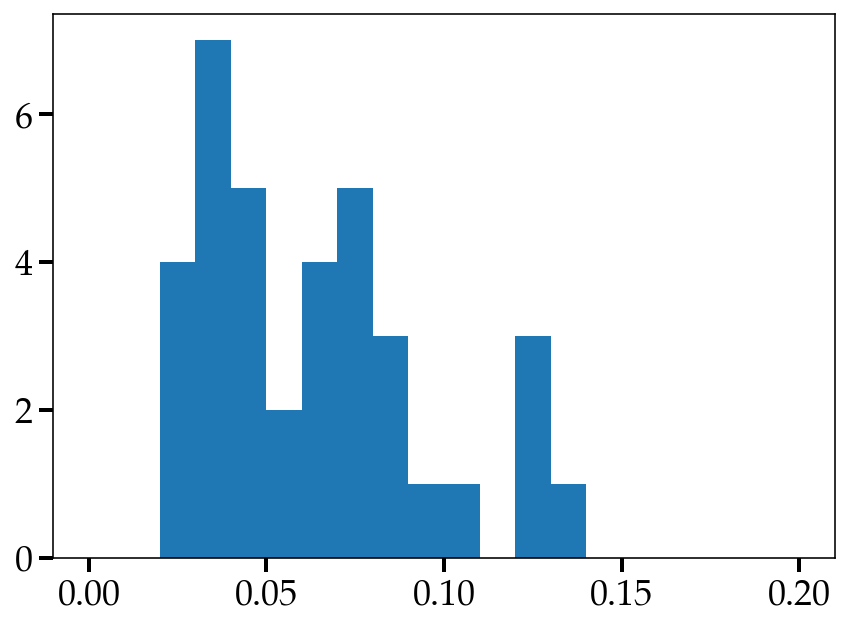

In [33]:
outlier_ia = outlier_df[outlier_df.tns_cls == "SN Ia"]
plt.hist(outlier_ia.spec_z, bins=np.linspace(0, 0.2, 21))

In [34]:
# anomaly scores ranked from most to least anomalous

In [35]:
anomaly_scores = IsolationForest(n_estimators=500, 
                                random_state=10, 
                                contamination=contamination,
                                max_features=12,
                                n_jobs=-1).fit(predicted_probability).decision_function(predicted_probability)

In [36]:
most_anomalous_indices = np.argsort(anomaly_scores)[:25]
most_anomalous_samples = df2.iloc[most_anomalous_indices]
print(most_anomalous_indices)
most_anomalous_samples

[428 446 126 329 414 143   7   1 373 266 431 203 118 251 407 104 296 280
 218 347 237 381 162 349 387]


,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,SN IIb,SN IIn,SN Ia,SN Ia-91T-like,SN Ib,SN Ic,SN Ic-BL,TDE,RFC_best_cls,in_out
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abpyauz,0.987303,1.645826,0.137931,0.034483,0.388388,1.893584,0.901166,0.565298,4.289138,0.002772,...,0.0,46.0,3.0,0.0,0.0,0.0,0.0,2.0,SN IIn,-1
ZTF21aaxwcgj,1.615225,2.271535,0.567568,0.000000,0.444366,3.224883,3.034625,2.295895,-1.594614,0.032740,...,4.0,21.0,13.0,1.0,3.0,7.0,10.0,1.0,SN IIn,-1
ZTF21aakigqr,0.339321,0.262226,0.200000,0.050000,0.350327,0.678642,0.362262,0.211516,0.764990,0.000725,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,SN II,-1
ZTF21abdahai,0.597616,0.894250,0.346154,0.038462,0.323741,1.185703,0.687144,0.266083,1.357526,0.006972,...,5.0,9.0,11.0,3.0,0.0,1.0,15.0,0.0,SN II,-1
ZTF20abqlmwn,0.906152,2.573259,0.467742,0.000000,0.444840,1.788699,1.441542,1.128241,-1.385934,0.008149,...,0.0,20.0,6.0,2.0,4.0,9.0,3.0,0.0,SN II,-1
ZTF21aautijg,0.678457,2.020706,0.171429,0.057143,0.343146,1.276674,0.609076,0.267091,5.422472,-0.000680,...,0.0,16.0,12.0,1.0,0.0,0.0,2.0,1.0,SLSN-II,-1
ZTF21abgkfzh,0.441565,0.789434,0.294118,0.088235,0.396573,0.869656,0.599177,0.282619,0.081786,0.004576,...,2.0,26.0,3.0,1.0,0.0,1.0,6.0,0.0,SN IIn,-1
ZTF21acgxypn,0.541942,0.743175,0.200000,0.000000,0.395337,1.083883,0.948133,0.494123,0.236500,0.001268,...,6.0,3.0,13.0,2.0,15.0,21.0,0.0,0.0,SN II,-1
ZTF21aaaalaf,0.538359,1.949543,0.250000,0.000000,0.453956,1.076717,0.928506,0.709736,-1.366982,0.024818,...,0.0,4.0,22.0,6.0,7.0,4.0,10.0,0.0,SN Ia,-1


In [37]:
Counter(most_anomalous_samples.tns_cls)

Counter({'SN II': 5,
         'SN Ia': 9,
         'SN IIn': 5,
         'SN Ic-BL': 2,
         'TDE': 3,
         'SN IIb': 1})

In [38]:
# most_anomalous_samples
for obj, cls, z, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.spec_z, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, round(z, 3), rfc_cls)

https://alerce.online/object/ZTF21abpyauz SN II 0.061 SN IIn
https://alerce.online/object/ZTF21aaxwcgj SN Ia 0.033 SN IIn
https://alerce.online/object/ZTF21aakigqr SN II 0.067 SN II
https://alerce.online/object/ZTF21abdahai SN II 0.04 SN II
https://alerce.online/object/ZTF20abqlmwn SN II 0.025 SN II
https://alerce.online/object/ZTF21aautijg SN IIn 0.106 SLSN-II
https://alerce.online/object/ZTF21abgkfzh SN IIn 0.086 SN IIn
https://alerce.online/object/ZTF21acgxypn SN Ic-BL 0.024 SN II
https://alerce.online/object/ZTF21aaaalaf SN Ia 0.05 SN Ia
https://alerce.online/object/ZTF21aapvvtb TDE 0.358 TDE
https://alerce.online/object/ZTF21aahfjrr SN IIn 0.194 SN IIn
https://alerce.online/object/ZTF18acvgjqv SN IIn 0.091 SN IIn
https://alerce.online/object/ZTF21aaabwfu SN IIb 0.011 SN Ib
https://alerce.online/object/ZTF21acmnpqa SN Ia 0.047 SN Ib
https://alerce.online/object/ZTF20acwytxn TDE nan SN IIn
https://alerce.online/object/ZTF21aafmkjk SN IIn 0.09 SN IIn
https://alerce.online/object/ZTF2

In [39]:
# for most part, the most anomalous stuff is pretty anomalous
# Ias are not super normal looking for most part (e.g., very red)

### inliers

In [40]:
Counter(inlier_df.tns_cls)

Counter({'SN Ia': 284,
         'SN II': 30,
         'SN IIb': 4,
         'SN IIP': 2,
         'SN Ic': 5,
         'SN Ic-BL': 3,
         'TDE': 1,
         'SN Ia-91T-like': 7,
         'SN IIn': 3,
         'SN Ib': 1,
         'SLSN-II': 1})

In [41]:
Counter(inlier_df.RFC_best_cls)

Counter({'SN Ia': 286,
         'SN II': 47,
         'TDE': 1,
         'SN IIn': 6,
         'SN Ia-91T-like': 1})

In [42]:
# all INLIERS - not anomalies
for obj, cls, z, rfc_cls in zip(inlier_df.index, inlier_df.tns_cls, inlier_df.spec_z, inlier_df.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, round(z, 3), rfc_cls)

https://alerce.online/object/ZTF21aazebgh SN Ia 0.076 SN Ia
https://alerce.online/object/ZTF21aasbxng SN Ia 0.041 SN Ia
https://alerce.online/object/ZTF21aaglgcb SN Ia 0.07 SN Ia
https://alerce.online/object/ZTF21aanwfjk SN Ia 0.065 SN Ia
https://alerce.online/object/ZTF21abcixor SN II 0.033 SN II
https://alerce.online/object/ZTF21aarerya SN Ia 0.13 SN Ia
https://alerce.online/object/ZTF21abvvuhm SN Ia 0.085 SN Ia
https://alerce.online/object/ZTF21abjtqyq SN Ia 0.097 SN Ia
https://alerce.online/object/ZTF21abotose SN IIb 0.041 SN Ia
https://alerce.online/object/ZTF21aafjjee SN Ia 0.049 SN Ia
https://alerce.online/object/ZTF21aamxduf SN Ia 0.1 SN Ia
https://alerce.online/object/ZTF21abvuttc SN Ia 0.067 SN Ia
https://alerce.online/object/ZTF20acppsay SN Ia 0.1 SN Ia
https://alerce.online/object/ZTF21accuexh SN Ia 0.072 SN Ia
https://alerce.online/object/ZTF21aaavhbu SN Ia 0.077 SN Ia
https://alerce.online/object/ZTF20acgprcg SN Ia 0.08 SN Ia
https://alerce.online/object/ZTF21achlshg SN I

# full test df

(array([ 2., 15., 43., 54., 52., 44., 56., 59., 42., 30., 19., 13.,  8.,
         6.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,  3.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]),
 <BarContainer object of 40 artists>)

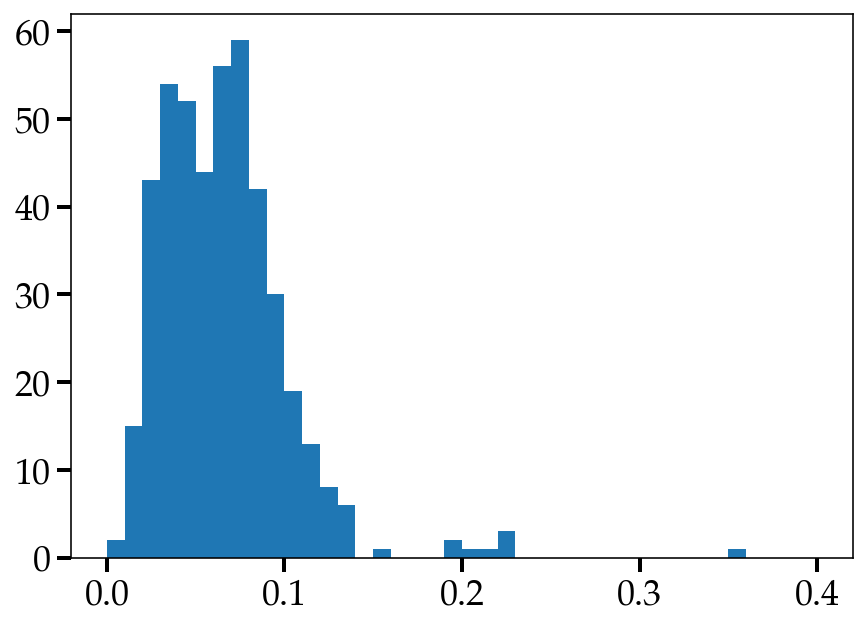

In [44]:
plt.hist(df2.spec_z, bins=np.linspace(0, 0.4, 41))

In [47]:
all_spec_z = np.array(df2.spec_z[~np.isnan(df2.spec_z)])

In [48]:
np.median(all_spec_z)

0.0611985

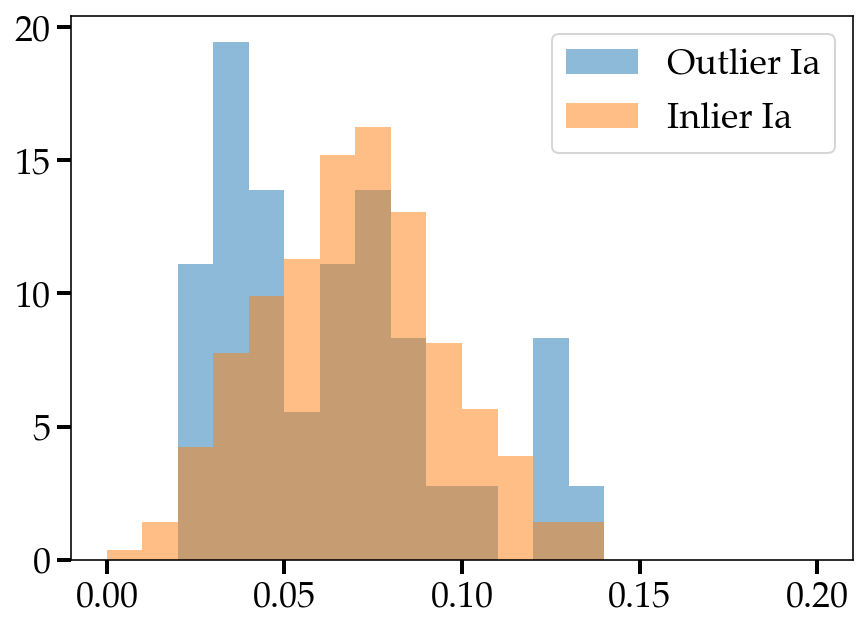

In [52]:
outliers_df_ia = outlier_df[outlier_df.tns_cls == "SN Ia"]
inliers_df_ia = inlier_df[inlier_df.tns_cls == "SN Ia"]


plt.hist(outliers_df_ia.spec_z, bins=np.linspace(0, 0.2, 21), alpha=0.5, label="Outlier Ia", density=True)
plt.hist(inliers_df_ia.spec_z, bins=np.linspace(0, 0.2, 21), alpha=0.5, label="Inlier Ia", density=True)
plt.legend()

In [53]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 1000 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(inliers_df_ia.spec_z, size=len(outliers_df_ia.spec_z), replace=False)
    stat, p_value = ks_2samp(outliers_df_ia.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.1891891891891892
P-value: 0.29356099391344065
The two distributions are likely the same.
